# Tutorial de Deep Learning -- Pytorch

**Importando bibliotecas**

In [1]:
## Importar as bibliotecas para carregar os dados com o pytorch
import torch
import os
import numpy as np
from torchvision import transforms, datasets, utils
import matplotlib.pyplot as plt

## Carregamento dados da MNIST

**Carregar as imagens da MNist e normalizar para a rede customizada**

In [124]:
#Aplicar a normalização na imagem
tf_image = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,))]
                            )
#importar a mnist
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=tf_image)
test_datset = datasets.MNIST(root='./data', train=False, download=True, transform=tf_image)

**Carregar as imagens da MNist e normalizar para a ResNet50**

In [125]:
#Aplicar a normalização na imagem
tf_image_resnet = transforms.Compose([transforms.ToTensor(),
                               transforms.Resize((224, 224), antialias=True),
                               transforms.Lambda(lambda x: x.repeat(3, 1, 1)), 
                               transforms.Normalize((0.5,), (0.5,))]
                            )
#importar a mnist
train_dataset_res = datasets.MNIST(root='./data', train=True, download=True, transform=tf_image_resnet)
test_datset_res = datasets.MNIST(root='./data', train=False, download=True, transform=tf_image_resnet)

**Consultar o número de exemplos**

In [126]:
print(f"num exemplos no treino: {len(train_dataset)}")
print(f"num exemplos no teste: {len(test_datset)}")

num exemplos no treino: 60000
num exemplos no teste: 10000


**Mostrar alguns exemplos de imagens**

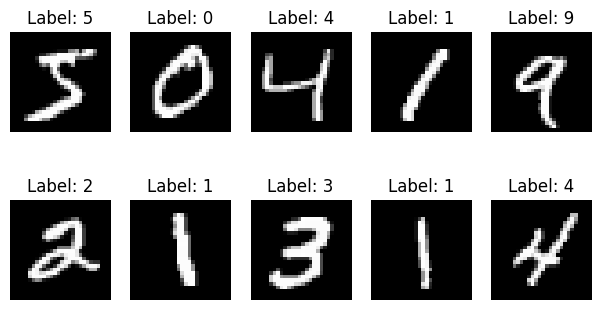

In [127]:
#Mostrar as imagens
num_row = 2
num_col = 5

plt.figure(figsize=(1.5*num_col,2*num_row))
for i in range(10):
    image, label = train_dataset[i]
    plt.subplot(num_row,num_col,i+1)
    plt.imshow(image[0].reshape(28,28), cmap='gray')
    plt.title('Label: {}'.format(label))
    plt.axis("off")
plt.show()

Transformar dados em um dataloader

In [128]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, num_workers=8, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_datset, batch_size=32, num_workers=8, shuffle=False)

In [129]:
train_loader_res = torch.utils.data.DataLoader(train_dataset_res, batch_size=32, num_workers=8, shuffle=True)
test_loader_res = torch.utils.data.DataLoader(train_dataset_res, batch_size=32, num_workers=8, shuffle=False)

## Construir o modelo

### Modelo customizado

In [130]:
class MyNet(torch.nn.Module):
    #Inicialização da rede
    def __init__(self):
        super(MyNet, self).__init__()
        #A camada convolucional de entrada recebe a image de input e tem como saíde 10 canais
        9# n_out = [(input_size + 2*padding - kernel)/stride]+ 1
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
        )
        # A conv 2 tem como entrada os 16 canais da anteriror
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
            torch.nn.Dropout(p=0.5),
        )
        #camadas conectadas
        self.fc1 = torch.nn.Linear(32*7*7, 50)
        #A ultima camada contém o numero de classes
        self.fc2 = torch.nn.Linear(50, 10)
        self.activation = torch.nn.Softmax(dim=1)
    
    def forward(self, x):
        #add a conv 1
        x = self.conv1(x)
        #add a conv 2
        x= self.conv2(x)
        
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.activation(x)
        
        return x

**Inicializando a rede customizada**

In [131]:
network = MyNet()

### Modelo a partir da ResNet50

In [2]:
#Importar as arquiteura limpa
from torchvision.models import resnet50
from torchvision.models.resnet import ResNet50_Weights

In [8]:
#criação e modificação do modelo
# Definição do modelo base pre-treinado na ImageNet
model_resnet = resnet50(weights=ResNet50_Weights.DEFAULT.transforms(antialias=True))

#Alteração das camadas para adicionar a camada que representa o número de classes
model_resnet.fc = torch.nn.Sequential(
    torch.nn.Linear(model_resnet.fc.in_features, 10),
    torch.nn.Softmax(dim=1)
)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Classe para o treinamento do modelo com o pytorch

**importar as bibliotecas de treinamento o pytorch lightning**

In [9]:
import lightning as L
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.loggers import TensorBoardLogger
from torchmetrics import Accuracy, F1Score


/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [10]:
class TrainTestModel(L.LightningModule):
    '''
        Classe para configuração do treinamento do modelo
        params:
            - model: model base para o treinamento
            - lr: taxa de aprendizado
    '''
    def __init__(self, model, lr):
        super().__init__()
        self.model = model
        self.lr = lr
        
        #definindo a função de perda
        self.loss = torch.nn.CrossEntropyLoss()
        
        #configuração das metricas
        self.train_acc = Accuracy(task='multiclass', num_classes=10)
        self.test_acc = Accuracy(task='multiclass', num_classes=10)
        
        self.train_f1 = F1Score(task="multiclass", num_classes=10, average="macro")
        self.test_f1 = F1Score(task="multiclass", num_classes=10, average="macro")
        

    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        #coleta os labels e imagens o batch
        x, y = batch
        
        #resultado da saida da rede, que é a softmax
        outputs = self.forward(x)
        
        #calculando a perda
        y_true = y.squeeze()
        loss_value = self.loss(outputs, y_true)
        
        #coletando os labels preditos
        y_pred = torch.argmax(outputs, dim=1)
        
        acc = self.train_acc(y_pred, y_true)
        f1 = self.train_f1(y_pred, y_true)
        
        self.log('loss', loss_value.item(), prog_bar=True)
        self.log('acc', acc, prog_bar=True)
        self.log('f1_score', f1, prog_bar=True)
        
        
        return loss_value
    
    def validation_step(self, batch, batch_idx):
        #coleta os labels e imagens o batch
        x, y = batch
        
        #resultado da saida da rede, que é a softmax
        outputs = self.forward(x)
        
        #calculando a perda
        y_true = y.squeeze()
        loss_value = self.loss(outputs, y_true)
        
        #coletando os labels preditos
        y_pred = torch.argmax(outputs, dim=1)
        
        acc = self.test_acc(y_pred, y_true)
        f1 = self.test_f1(y_pred, y_true)
        
        self.log('val_loss', loss_value.item(), prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        self.log('val_f1_score', f1, prog_bar=True)
        
        return loss_value

    def configure_optimizers(self):
        opt = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        
        return [opt]

## Treinamento do Modelo para a MNIST

### Treinamento para o model customizado

In [132]:
# carregar o module de treinamento
ligth_train = TrainTestModel(model=network, lr=0.01)

#configuração do early stopping
early = EarlyStopping(monitor='val_acc', min_delta=0.01, patience=5, mode='max')

#configuração do tensorboard para salvar os experimentos
#logger = TensorBoardLogger(save_dir="logs", name="my-model")

#modulo para execução do treinamento
trainer = L.Trainer(
    max_epochs=10,
    accelerator='gpu',
    devices='auto',
    min_epochs=5,
    #logger=logger,
    #callbacks=[early]
)

#executar o treinamento e teste
trainer.fit(
    model=ligth_train,
    train_dataloaders=train_loader,
    val_dataloaders=test_loader
)

metrics = trainer.logged_metrics
print(metrics)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | MyNet              | 92.2 K
1 | loss      | CrossEntropyLoss   | 0     
2 | train_acc | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
4 | train_f1  | MulticlassF1Score  | 0     
5 | test_f1   | MulticlassF1Score  | 0     
-------------------------------------------------
92.2 K    Trainable params
0         Non-trainable params
92.2 K    Total params
0.369     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 1875/1875 [00:12<00:00, 155.91it/s, v_num=19, loss=2.370, acc=0.0938, f1_score=0.0171, val_loss=2.360, val_acc=0.0982, val_f1_score=0.0175] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1875/1875 [00:12<00:00, 155.81it/s, v_num=19, loss=2.370, acc=0.0938, f1_score=0.0171, val_loss=2.360, val_acc=0.0982, val_f1_score=0.0175]
{'loss': tensor(2.3674), 'acc': tensor(0.0938), 'f1_score': tensor(0.0171), 'val_loss': tensor(2.3629), 'val_acc': tensor(0.0982), 'val_f1_score': tensor(0.0175)}


### Treinamento para a ResNet

In [133]:
# carregar o module de treinamento
ligth_train = TrainTestModel(model=model_resnet, lr=0.001)

#configuração do early stopping
early = EarlyStopping(monitor='val_acc', min_delta=0.01, patience=5, mode='max')

#configuração do tensorboard para salvar os experimentos
#logger = TensorBoardLogger(save_dir="logs", name="my-model")

#modulo para execução do treinamento
trainer = L.Trainer(
    max_epochs=10,
    accelerator='gpu',
    devices='auto',
    min_epochs=5,
    #logger=logger,
    #callbacks=[early]
)

#executar o treinamento e teste
trainer.fit(
    model=ligth_train,
    train_dataloaders=train_loader_res,
    val_dataloaders=test_loader_res
)

metrics = trainer.logged_metrics
print(metrics)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | ResNet             | 23.5 M
1 | loss      | CrossEntropyLoss   | 0     
2 | train_acc | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
4 | train_f1  | MulticlassF1Score  | 0     
5 | test_f1   | MulticlassF1Score  | 0     
-------------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.114    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch 0:   0%|          | 0/1875 [00:00<?, ?it/s] 

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch 0:   9%|▉         | 174/1875 [00:33<05:30,  5.15it/s, v_num=20, loss=2.000, acc=0.438, f1_score=0.353]

OutOfMemoryError: CUDA out of memory. Tried to allocate 98.00 MiB (GPU 0; 7.79 GiB total capacity; 6.01 GiB already allocated; 62.00 MiB free; 7.51 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

## Base de imagens de CT-Scan

### Criar o custom dataset

In [11]:
from torchvision.datasets import ImageFolder

In [12]:
class CTDataset(torch.utils.data.Dataset):
    '''
        classe para importar imagens de uma classe especifica
        fonte: https://www.kaggle.com/datasets/mohamedhanyyy/chest-ctscan-images
        params:
            - path: caminho para o repositório de imagens
            - tf_image: normaliza a imagem
    '''
    def __init__(self, path, tf_image, train=True, test=False, val=False):
        
        #selecionar a partição de dados que será coletada da pasta
        if test:
            self.data = ImageFolder(root=os.path.join(path, 'test'), transform=tf_image)
        elif val:
            self.data = ImageFolder(root=os.path.join(path, 'valid'), transform=tf_image)
        else:
            self.data = ImageFolder(root=os.path.join(path, 'train'), transform=tf_image)
        
        # self.X = []
        # self.y = []
        
        # self.X, self.y = zip(*[(x, y) for x, y in self.dataset])
        
        # self.X = torch.stack(list(self.X))
        # self.y = torch.tensor(list(self.y))
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        x = self.data[idx][0]
        y = self.data[idx][1]
        
        return x, y

In [13]:
tf_image_ct = transforms.Compose([transforms.ToTensor(),
                                  transforms.Resize((224, 224), antialias=True),
                                  #transforms.Lambda(lambda x: x.repeat(3, 1, 1)),   
                                  #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                  transforms.Normalize((0.5,), (0.5,)),
])

In [14]:
train_data_ct = CTDataset(path="./data/CT/", tf_image=tf_image_ct , train=True, test=False, val=False)
test_data_ct = CTDataset(path="./data/CT/", tf_image=tf_image_ct , train=False, test=True, val=False)
val_data_ct = CTDataset(path="./data/CT/", tf_image=tf_image_ct , train=False, test=False, val=True)

In [15]:
print(f"num exemplos no treino: {len(train_data_ct)}")
print(f"num exemplos no teste: {len(test_data_ct)}")
print(f"num exemplos na validacao: {len(val_data_ct)}")

num exemplos no treino: 613
num exemplos no teste: 315
num exemplos na validacao: 72


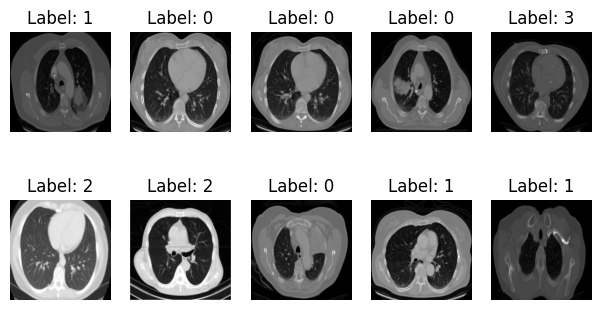

In [16]:
#Mostrar as imagens
num_row = 2
num_col = 5
idx_rnd = np.random.randint(0, len(train_data_ct), 10).astype(int)
plt.figure(figsize=(1.5*num_col,2*num_row))
for i, idx in enumerate(idx_rnd):
    image, label = train_data_ct[idx]
    plt.subplot(num_row,num_col,i+1)
    plt.imshow(image[0], cmap='gray')
    plt.title('Label: {}'.format(label))
    plt.axis("off")
plt.show()

In [17]:
train_loader_ct = torch.utils.data.DataLoader(train_data_ct, batch_size=32, num_workers=8, shuffle=True)
test_loader_ct = torch.utils.data.DataLoader(test_data_ct, batch_size=32, num_workers=8, shuffle=False)
val_loader_ct = torch.utils.data.DataLoader(val_data_ct, batch_size=32, num_workers=8, shuffle=False)

### Treinamento para a base de CT

In [18]:
# carregar o module de treinamento
ligth_train = TrainTestModel(model=model_resnet, lr=0.001)

#configuração do early stopping
early = EarlyStopping(monitor='val_acc', min_delta=0.01, patience=5, mode='max')

#configuração do tensorboard para salvar os experimentos
#logger = TensorBoardLogger(save_dir="logs", name="my-model")

#modulo para execução do treinamento
trainer = L.Trainer(
    max_epochs=10,
    accelerator='gpu',
    devices='auto',
    min_epochs=5,
    #logger=logger,
    #callbacks=[early]
)

#executar o treinamento e teste
trainer.fit(
    model=ligth_train,
    train_dataloaders=train_loader_ct,
    val_dataloaders=test_loader_ct
)

metrics = trainer.logged_metrics
print(metrics)

/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | ResNet             | 23.5 M
1 | loss      | CrossEntropyLoss   | 0     
2 | train_acc | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
4 | train_f1  | MulticlassF1Score  | 0     
5 | test_f1   | MulticlassF1Score  | 0     
-------------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.114    Total estimated model params size (MB)
2023-06-04 18:41:16.015548: I tensorflow/core/platform/cpu_feature_guard.c

/home/eriksonaguiar/.local/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (20) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 9: 100%|██████████| 20/20 [00:06<00:00,  3.32it/s, v_num=18, loss=1.870, acc=0.600, f1_score=0.217, val_loss=2.020, val_acc=0.435, val_f1_score=0.073]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 20/20 [00:06<00:00,  3.03it/s, v_num=18, loss=1.870, acc=0.600, f1_score=0.217, val_loss=2.020, val_acc=0.435, val_f1_score=0.073]
{'loss': tensor(1.8684), 'acc': tensor(0.6000), 'f1_score': tensor(0.2167), 'val_loss': tensor(2.0214), 'val_acc': tensor(0.4349), 'val_f1_score': tensor(0.0730)}
